**Worked on the mental health in tech data and explored the mutual information and the distance matrix between all pairs of variables and then produced a hierarchical clustering** <br>
https://www.kaggle.com/datasets/osmi/mental-health-in-tech-survey.

In [1]:
library(cluster)
library(infotheo)
library(farver)
library(factoextra)
library(NbClust)
library(caret)
library(corrgram)
library(ggplot2)
library(pROC)

Loading required package: ggplot2

Welcome! Want to learn more? See two factoextra-related books at https://goo.gl/ve3WBa

Loading required package: lattice


Attaching package: 'corrgram'


The following object is masked from 'package:lattice':

    panel.fill


Type 'citation("pROC")' for a citation.


Attaching package: 'pROC'


The following objects are masked from 'package:stats':

    cov, smooth, var




In [2]:
survey = read.csv("survey.csv", stringsAsFactors = TRUE)
head(survey)

,Timestamp,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,⋯,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
,<fct>,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,2014-08-27 11:29:31,37,Female,United States,IL,NA,No,Yes,Often,6-25,⋯,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,NA
2,2014-08-27 11:29:37,44,M,United States,IN,NA,No,No,Rarely,More than 1000,⋯,Don't know,Maybe,No,No,No,No,No,Don't know,No,NA
3,2014-08-27 11:29:44,32,Male,Canada,NA,NA,No,No,Rarely,6-25,⋯,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,NA
4,2014-08-27 11:29:46,31,Male,United Kingdom,NA,NA,Yes,Yes,Often,26-100,⋯,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,NA
5,2014-08-27 11:30:22,31,Male,United States,TX,NA,No,No,Never,100-500,⋯,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,NA
6,2014-08-27 11:31:22,33,Male,United States,TN,NA,Yes,No,Sometimes,6-25,⋯,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No,NA


In [3]:
unique(survey$Gender)

[1] Female                                        
 [2] M                                             
 [3] Male                                          
 [4] male                                          
 [5] female                                        
 [6] m                                             
 [7] Male-ish                                      
 [8] maile                                         
 [9] Trans-female                                  
[10] Cis Female                                    
[11] F                                             
[12] something kinda male?                         
[13] Cis Male                                      
[14] Woman                                         
[15] f                                             
[16] Mal                                           
[17] Male (CIS)                                    
[18] queer/she/they                                
[19] non-binary                                    
[20] Femake                                        
[21] woman                                         
[22] Make                                          
[23] Nah                                           
[24] All                                           
[25] Enby                                          
[26] fluid                                         
[27] Genderqueer                                   
[28] Female                                        
[29] Androgyne                                     
[30] Agender                                       
[31] cis-female/femme                              
[32] Guy (-ish) ^_^                                
[33] male leaning androgynous                      
[34] Male                                          
[35] Man                                           
[36] Trans woman                                   
[37] msle                                          
[38] Neuter                                        
[39] Female (trans)                                
[40] queer                                         
[41] Female (cis)                                  
[42] Mail                                          
[43] cis male                                      
[44] A little about you                            
[45] Malr                                          
[46] p                                             
[47] femail                                        
[48] Cis Man                                       
[49] ostensibly male, unsure what that really means
49 Levels: A little about you Agender All Androgyne ... Woman

In [4]:
# Standardize gender column and limit the category numbers to only 3
survey$Gender = as.character(survey$Gender)
inds_male = which(survey$Gender %in% c("Male", "M", "Make", "msle", "Cis Man", "Mail", "m", "Male-ish", 
                                       "maile", "Mair", "Malr", "something kinda male?", "Cis Male", 
                                       "cis male", "Guy (-ish) ^_^", "Man", "Male (CIS)", "Mal", "Male "))
survey$Gender[inds_male] = "male"

inds_female = which(survey$Gender %in% c("Female", "F", "Cis Female", "f", "femail", "Female (cis)", 
                                         "Woman", "woman", "Femake", "Female ", "Trans woman", "Female (trans)", 
                                         "Trans-female", "cis-female/femme"))
survey$Gender[inds_female] = "female"

inds_other = which(survey$Gender != "male" & survey$Gender != "female")

survey$Gender[inds_other] = "other"

#convert gender column back to factor
survey$Gender = as.factor(survey$Gender)

In [5]:
#remove state and comment columns, since they have too many null values and they do not help us with our prediction that much
survey_1 = survey[,-c(1, 5, 27)]
head(survey_1)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,⋯,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,37,female,United States,NA,No,Yes,Often,6-25,No,Yes,⋯,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
2,44,male,United States,NA,No,No,Rarely,More than 1000,No,No,⋯,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
3,32,male,Canada,NA,No,No,Rarely,6-25,No,Yes,⋯,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
4,31,male,United Kingdom,NA,Yes,Yes,Often,26-100,No,Yes,⋯,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
5,31,male,United States,NA,No,No,Never,100-500,Yes,Yes,⋯,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
6,33,male,United States,NA,Yes,No,Sometimes,6-25,No,Yes,⋯,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No


In [6]:
#Observing any unreasonable age value.(Working under age 14 is not legal)
survey_1[which(survey_1$Age > 100 | survey_1$Age <14),]

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,⋯,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
,<dbl>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
144,-2.900e+01,male,United States,No,No,No,NA,More than 1000,Yes,No,⋯,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No
365,3.290e+02,male,United States,No,No,Yes,Often,6-25,Yes,Yes,⋯,Don't know,Don't know,Maybe,No,Some of them,No,No,No,No,No
391,1.000e+11,other,Zimbabwe,Yes,Yes,Yes,Often,1-5,No,Yes,⋯,No,Very difficult,Yes,Yes,No,No,Yes,No,No,Yes
716,-1.726e+03,male,United Kingdom,No,No,Yes,Sometimes,26-100,No,No,⋯,Don't know,Somewhat difficult,Yes,No,No,No,No,Maybe,Don't know,No
735,5.000e+00,male,United States,No,No,No,NA,100-500,No,Yes,⋯,Don't know,Somewhat easy,No,No,Yes,Yes,No,No,Yes,No
990,8.000e+00,other,"Bahamas, The",Yes,Yes,Yes,Often,1-5,Yes,Yes,⋯,Yes,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes
1091,1.100e+01,male,United States,Yes,No,No,Never,1-5,Yes,Yes,⋯,Yes,Very easy,No,No,Some of them,Some of them,No,Maybe,Yes,No
1128,-1.000e+00,other,United States,Yes,Yes,Yes,Often,1-5,Yes,Yes,⋯,Yes,Very easy,Yes,Yes,Yes,Yes,Yes,Yes,Yes,Yes


In [7]:
# Replace age values that are not in (0,100) with the mean of the age column
mean_age = mean(survey_1$Age[which(survey_1$Age < 100 & survey_1$Age > 13)])
survey_1$Age[which(survey_1$Age > 100 | survey_1$Age <14)] = mean_age

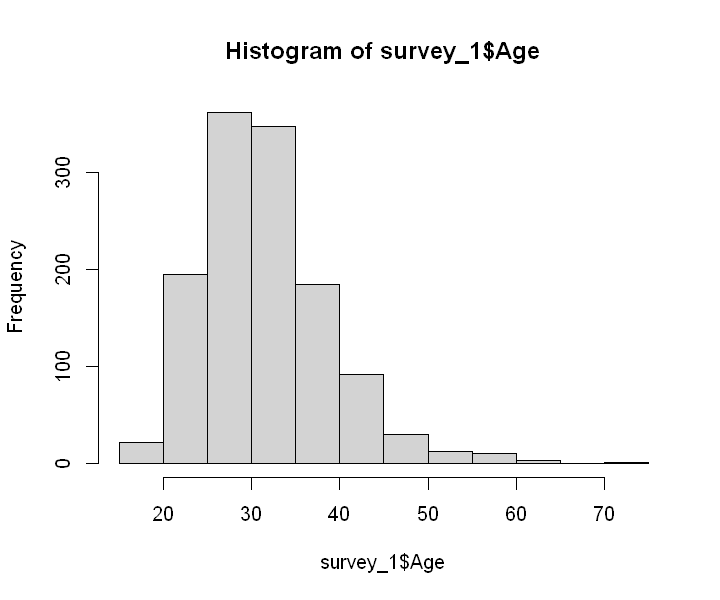

In [8]:
#Check to see how the Age column is distributed
options(repr.plot.width =6 , repr.plot.height =5)
hist(survey_1$Age)

In [9]:
#Replace Na values in work_interfere column with the most frequent value
survey_1$work_interfere[which(is.na(survey_1$work_interfere))] = "Sometimes"

In [10]:
#Replace Na values in self_employed column with the most frequent value 
survey_1$self_employed = as.character(survey_1$self_employed)
survey_1$self_employed[which(is.na(survey_1$self_employed))] = "No"
survey_1$self_employed = as.factor(survey_1$self_employed)

In [11]:
#any null value?
sum(is.na(survey_1))

[1] 0

**Mutual Information**

In [164]:
#Create the mutual information matrix
survey_1$Age = as.integer(survey_1$Age)
mi_matrix = matrix(data = NA, nrow = ncol(survey_1), ncol = ncol(survey_1))

#Fill in the mi matrix
for (i in 1:ncol(survey_1) ){
    for (j in 1:ncol(survey_1) ){
        mi_matrix[i,j] = mutinformation(as.integer(survey_1[,i]), as.integer(survey_1[,j]))
        }
    }
print(mi_matrix)

            [,1]         [,2]       [,3]         [,4]         [,5]         [,6]
 [1,] 3.29918691 0.0272447699 0.31393857 2.337907e-02 2.811542e-02 0.0187108483
 [2,] 0.02724477 0.5614765367 0.03801611 2.851690e-03 1.231803e-02 0.0214672476
 [3,] 0.31393857 0.0380161092 1.69044265 3.667308e-02 2.966592e-02 0.0344575231
 [4,] 0.02337907 0.0028516897 0.03667308 3.588078e-01 4.873666e-05 0.0002101717
 [5,] 0.02811542 0.0123180264 0.02966592 4.873666e-05 6.690985e-01 0.0737510603
 [6,] 0.01871085 0.0214672476 0.03445752 2.101717e-04 7.375106e-02 0.6930762046
 [7,] 0.05098632 0.0074030129 0.05371125 3.726702e-03 2.607712e-02 0.0921264580
 [8,] 0.10446541 0.0102163822 0.11372653 1.303723e-01 4.230761e-03 0.0034874532
 [9,] 0.02781728 0.0001116116 0.03494093 4.536203e-02 1.043034e-04 0.0003629576
[10,] 0.02336071 0.0030891690 0.02284204 3.674246e-03 1.051166e-03 0.0004974362
[11,] 0.04837998 0.0113629300 0.14870008 3.694121e-02 1.116231e-02 0.0260699128
[12,] 0.04152587 0.0087947398 0.06887748

Mutual information between each pair of variables shows how much information one contains about the other one; in other words, how much our uncertainty about one is decreased by knowing the other one. Column 6 (or row 6) of mi_matrix shows how much our uncertainty about the response variable decreases by knowing only one of the features.

In [13]:
uncertainty = sort(mi_matrix[,6], index=TRUE, decreasing = TRUE)
names(uncertainty) = c("Mutual Informarion", "Column Index")
uncertainty

$`Mutual Informarion`
 [1] 0.6930762046 0.0921264580 0.0737510603 0.0383761471 0.0344575231
 [6] 0.0260699128 0.0214672476 0.0187108483 0.0126234974 0.0120901305
[11] 0.0105545997 0.0089064002 0.0069644294 0.0050686536 0.0045892352
[16] 0.0043623158 0.0034874532 0.0023893123 0.0013514176 0.0013433081
[21] 0.0006854294 0.0004974362 0.0003629576 0.0002101717

$`Column Index`
 [1]  6  7  5 12  3 11  2  1 24 16 15 17 23 21 13 14  8 19 22 18 20 10  9  4

In [30]:
uncertainty$"Mutual Informarion"[2] / uncertainty$"Mutual Informarion"[1]

[1] 0.132924

Above numbers are showing the connection between each feature and the response variable in decreasing order. \
The first value is our uncertainty about the response variable. 

The most informative feature (variable 7:work_interfere) only explaines 13% of the uncertainty in the response variable and most of the other features are almost uninformative. 

**Distance Matrix**

A distance matrix is a table that shows the distance between pairs of objects. So firstly we need to handle our categorical data to be able to calculate the distance from them. We can encode our categorical data to convert it to numerical values but still there would be no numerical meaning behind each number and they only represent a specific category. It might be better to use one hot encoding method for handling our categorical data.

In [14]:
dmy = dummyVars(" ~ .", data=survey_1[,-6], fullRank=T)
survey_dmy <- data.frame(predict(dmy, newdata = survey_1[,-6]))
head(survey_dmy)

,Age,Gender.male,Gender.other,Country.Austria,Country.Bahamas..The,Country.Belgium,Country.Bosnia.and.Herzegovina,Country.Brazil,Country.Bulgaria,Country.Canada,⋯,coworkers.Yes,supervisor.Some.of.them,supervisor.Yes,mental_health_interview.No,mental_health_interview.Yes,phys_health_interview.No,phys_health_interview.Yes,mental_vs_physical.No,mental_vs_physical.Yes,obs_consequence.Yes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,37,0,0,0,0,0,0,0,0,0,⋯,0,0,1,1,0,0,0,0,1,0
2,44,1,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,0,0
3,32,1,0,0,0,0,0,0,0,1,⋯,1,0,1,0,1,0,1,1,0,0
4,31,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,1
5,31,1,0,0,0,0,0,0,0,0,⋯,0,0,1,0,1,0,1,0,0,0
6,33,1,0,0,0,0,0,0,0,0,⋯,1,0,1,1,0,0,0,0,0,0


The **distance matrix** contains the distances between pairs of observations. 


In [17]:
survey.dist = dist(survey_dmy[,c(-6)], method = "euclidean")
survey.dist

             1         2         3         4         5         6         7
2     8.124038                                                            
3     6.708204 12.688578                                                  
4     7.810250 13.820275  4.472136                                        
5     7.071068 13.490738  3.872983  4.795832                              
6     5.099020 11.575837  3.872983  5.196152  4.000000                    
7     4.795832  9.746794  5.291503  5.477226  5.744563  4.358899          
8     4.690416  6.164414  7.810250  9.000000  8.944272  7.211103  5.385165
9     6.557439  4.582576 10.862780 11.832160 11.704700  9.539392  7.874008
10   14.525839 21.283797  9.591663  9.165151  8.660254 10.535654 12.806248
11    6.928203 13.416408  3.872983  4.582576  3.162278  3.464102  5.000000
12    9.055385 15.556349  4.358899  5.196152  3.464102  5.291503  7.416198
13    6.928203  4.898979 10.908712 11.532563 11.916375  9.797959  8.062258
14    3.741657  8.602325 

**Hierarchical clustering of the distance matrix**

Hierarchical clustering is iteratively grouping observations into clusters using the distance matrix.

In [18]:
survey.hclust.fit = hclust(survey.dist, method="ward")

The "ward" method has been renamed to "ward.D"; note new "ward.D2"



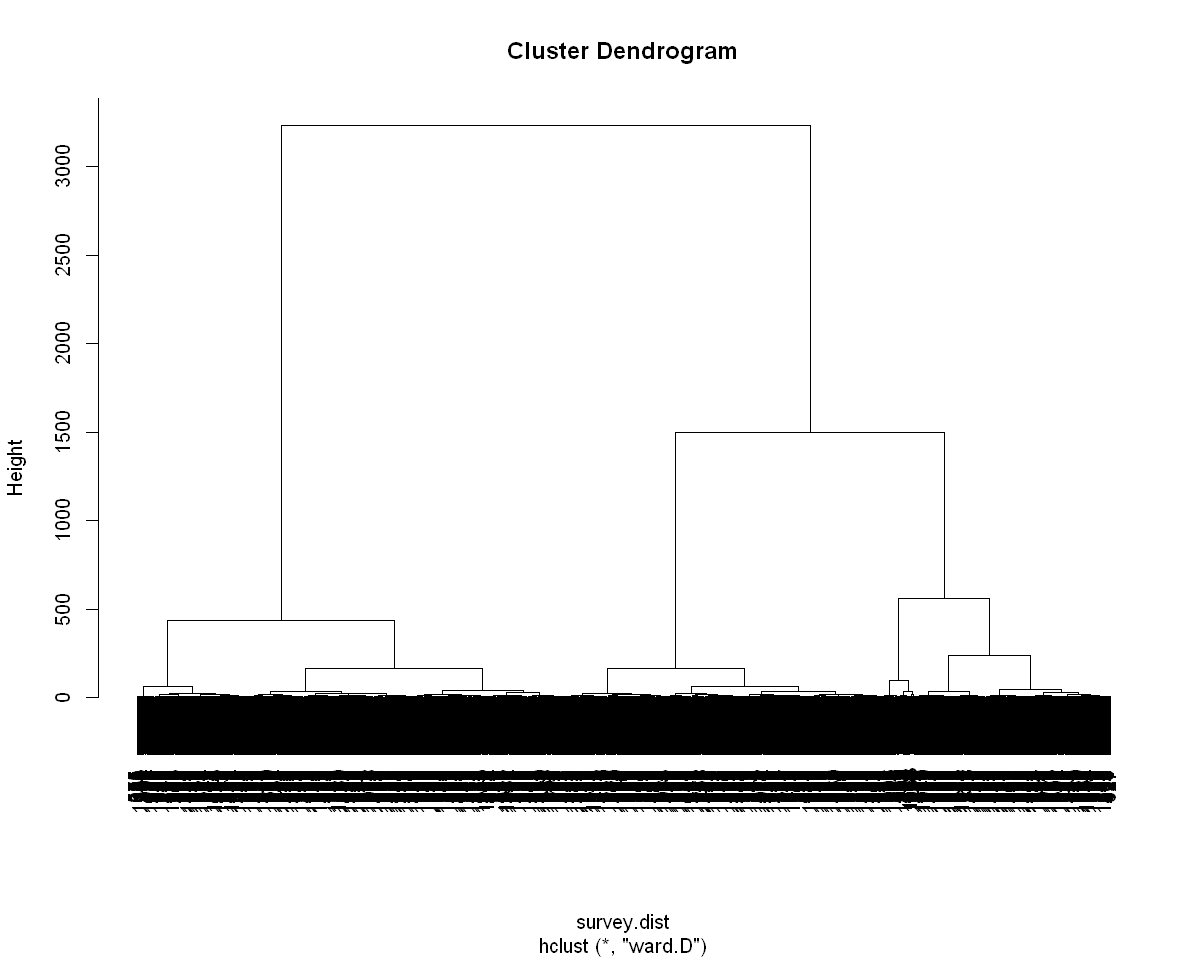

In [19]:
options(repr.plot.width =10 , repr.plot.height =8)
plot(survey.hclust.fit)

The above plot is showing the hierarchical relationship between objects and it is the summary of the distance matrix that we obtained in the previous part. The height at which any two objects are joined together tells us how similar those objects are. 

**Prune Tree**

With the help of fviz_nbclust() function we will plot the elbow graph for our wss to find the optimum number of clusters.

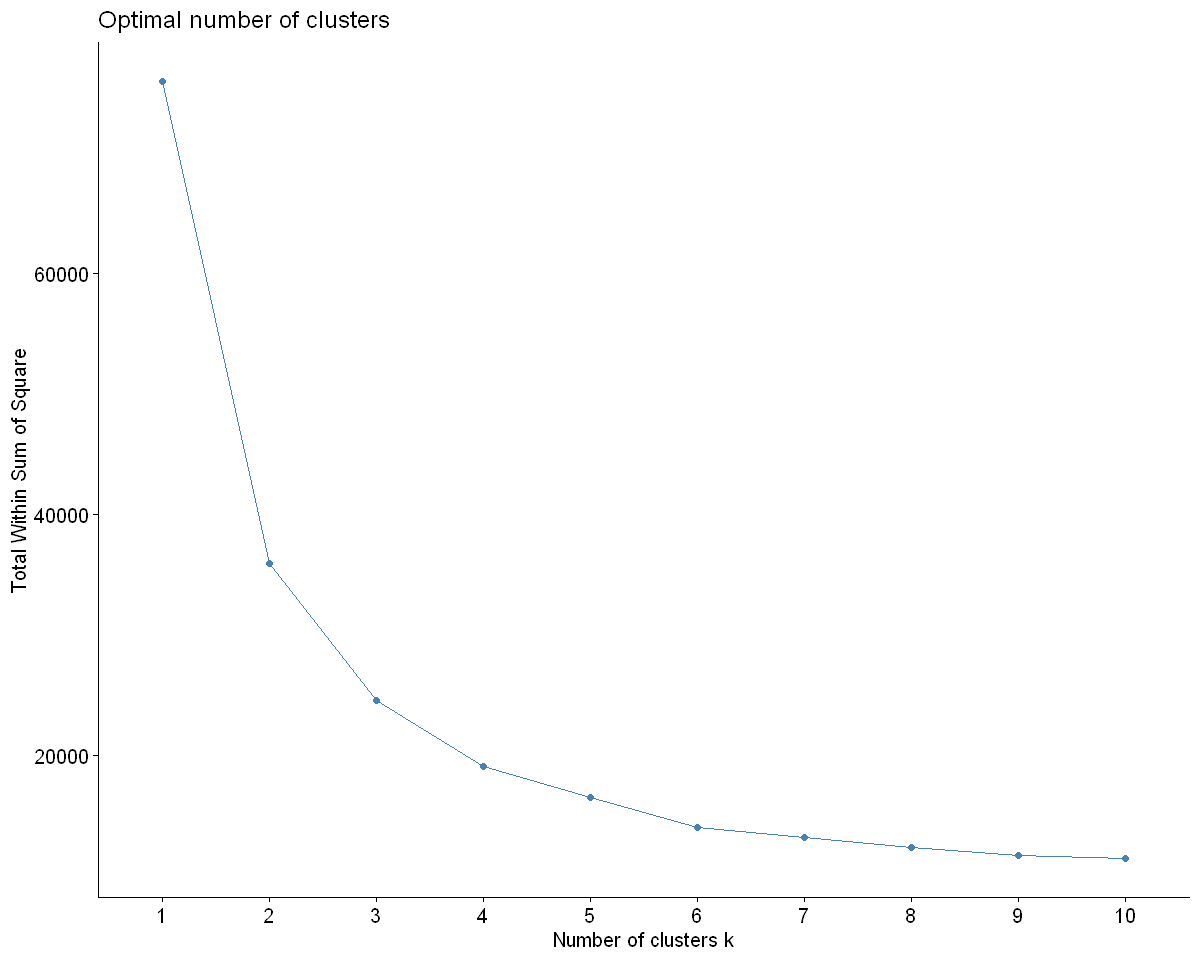

In [20]:
fviz_nbclust(survey_dmy, 
             FUNcluster = hcut,
             method = "wss"
             ) 

The elbow plot is suggesting that k=3 would be the optimum number of clusters. 

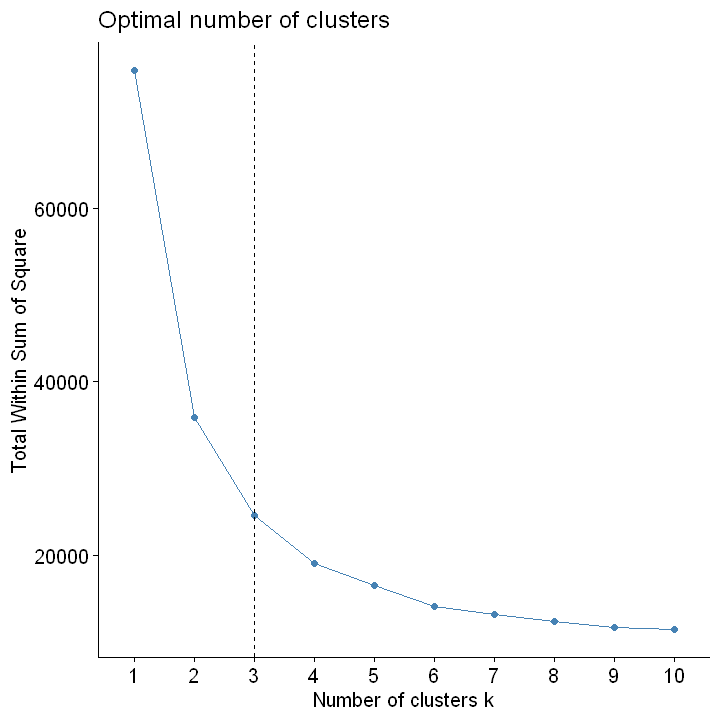

In [21]:
options(repr.plot.width =6 , repr.plot.height =6)
fviz_nbclust(survey_dmy, 
             FUNcluster = hcut,
             method = "wss"
             ) + 
geom_vline(xintercept = 3, linetype = 2)


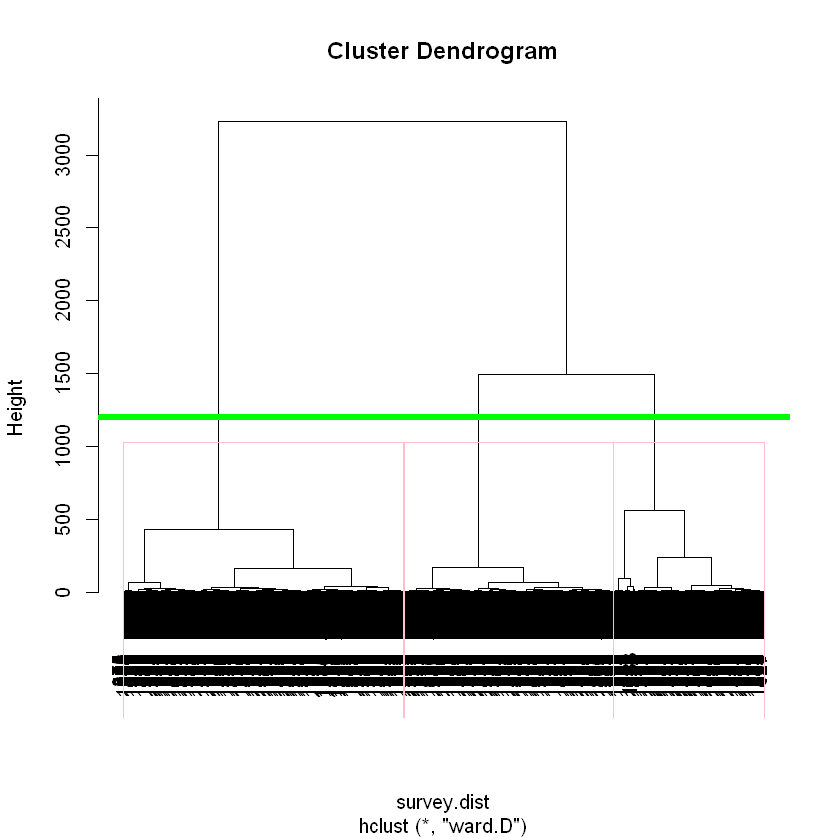

In [22]:
# h =1200 will be equal to having 3 clusters.
options(repr.plot.width =7 , repr.plot.height =7)
plot(survey.hclust.fit)
groups = cutree(survey.hclust.fit, h=1200)
rect.hclust(survey.hclust.fit, k=3, border="pink")
abline(h = 1200, col = "green", lwd=5)

In [23]:
table(hcluster = groups, treatment = survey_1$treatment)

        treatment
hcluster  No Yes
       1 127 169
       2 202 210
       3 293 258

We see that eventhough this is the optimal number of clusters, our model is not still very suitable for our data, which could be due to the fact that the features are not very informative about the response variable. (We got the same conclusion from the mutual information matrix in the previous part.)
Basically the model just splitted the "Yes" and "No" values 50/50 in each cluster.

**Kmedoids**

Now we are going to cluster our data with kmedoids method. \
Let's see how our data is distributed into clusters of 2, 3 and 5 clusters as a start.

In [31]:
model_pam = pam(survey_1[,c(-6)], 2)
table(clusters = model_pam$cluster, treatment = survey_1$treatment)

        treatment
clusters  No Yes
       1 460 519
       2 162 118

In [32]:
model_pam = pam(survey_1[,c(-6)], 3)
table(clusters = model_pam$cluster, treatment = survey_1$treatment)

        treatment
clusters  No Yes
       1 135 179
       2 156 113
       3 331 345

In [33]:
model_pam = pam(survey_1[,c(-6)], 5)
table(clusters = model_pam$cluster, treatment = survey_1$treatment)

        treatment
clusters  No Yes
       1 182 205
       2  75 114
       3  64  58
       4 202 200
       5  99  60

We observe that in all three different cluster numbers, our data is distributed into clusters almost 50/50. This means that most of the clusters did not do a great job in grouping the similar data together and differentiating "Yes" and "No" values in our "treatment" column.
Kmedoids computes the dissimilarity between the data and it is not very meaningful for categorical data.  Let's use our dummy variables for the kmedoid too.

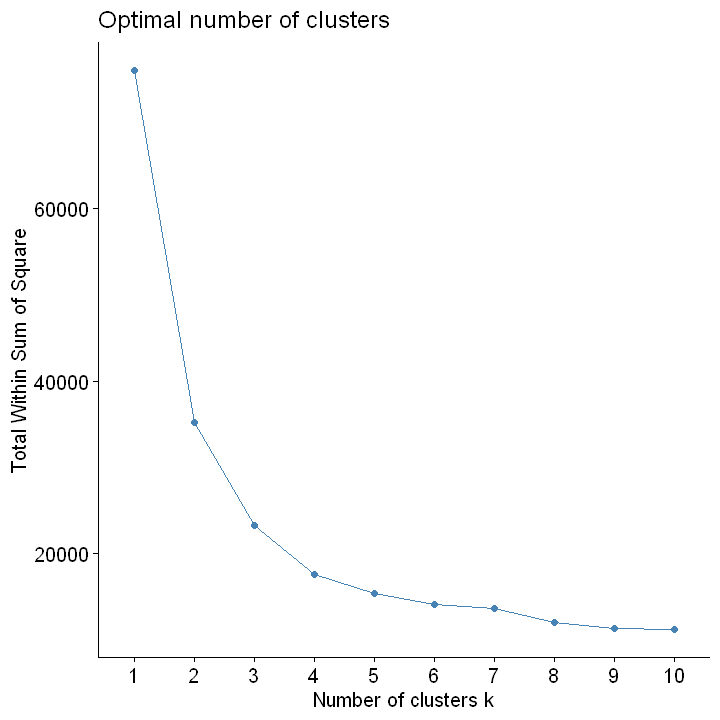

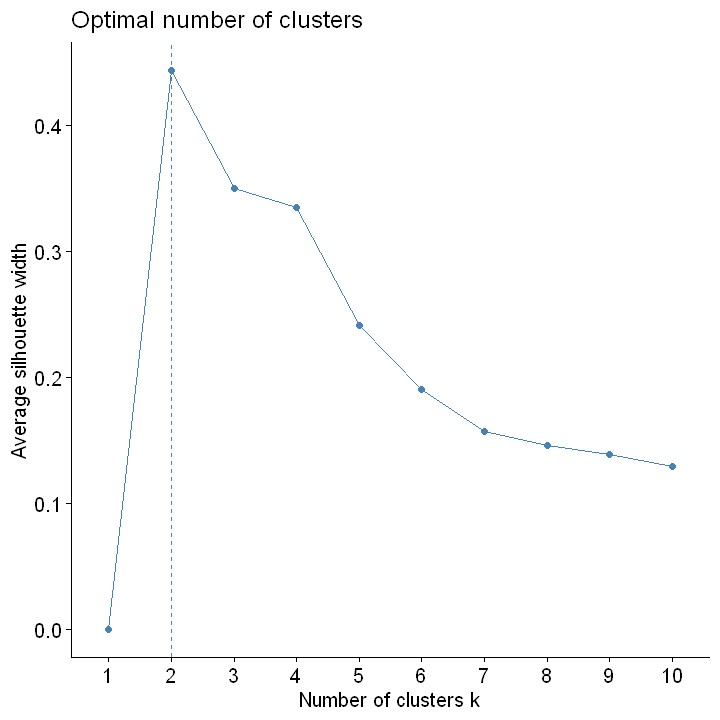

In [34]:
#optimal number of clusters with two different methods using fviz_nbclust() function: wss and silhouette
options(repr.plot.width =6 , repr.plot.height =6)

fviz_nbclust(survey_dmy, 
             FUNcluster = pam, 
             method = "wss", 
             k.max = 10) 

fviz_nbclust(survey_dmy, 
             FUNcluster = pam, 
             method = "silhouette", 
             k.max = 10)


The silhouette method suggests 2 as the optimal number of clusters, however for wss method we can say that k=3 is the optimal number which is similar to the optimal number of clusters that we got from the hierarchical clustering method. Since we only have 2 labels in our response data, it makes sense to have 2 number of clusters as the optimal number and not more than that.

In [35]:
# Note that we used dummy variables
model_pam_dmy= pam(survey_dmy[,c(-6)], 2)
table(clusters = model_pam_dmy$cluster, treatment = survey_1$treatment)

        treatment
clusters  No Yes
       1 215 255
       2 407 382

We can see that our model is still not doing a good job in clustering the "Yes" and "No" values, eventhough we are using the optimal number of clusters. \
This could be due to the fact that the features are not very informative about the response variable. (We got the same conclusion from the mutual information matrix and the hierarchical clustering in the previous parts.)

**Medoids similarities and differences:**

In [37]:
medoid_centers = survey_dmy[rownames(model_pam_dmy$medoids),]
medoid_centers

,Age,Gender.male,Gender.other,Country.Austria,Country.Bahamas..The,Country.Belgium,Country.Bosnia.and.Herzegovina,Country.Brazil,Country.Bulgaria,Country.Canada,⋯,coworkers.Yes,supervisor.Some.of.them,supervisor.Yes,mental_health_interview.No,mental_health_interview.Yes,phys_health_interview.No,phys_health_interview.Yes,mental_vs_physical.No,mental_vs_physical.Yes,obs_consequence.Yes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
570,38,1,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,0,0
115,28,1,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,0,0,0,0,0


In [38]:
#Differences between medoids
different_var = medoid_centers[1,] != medoid_centers[2,]
medoid_centers[,different_var]

,Age,family_history.Yes,no_employees.100.500,no_employees.More.than.1000,seek_help.No,phys_health_consequence.No,phys_health_interview.No
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
570,38,1,1,0,1,0,1
115,28,0,0,1,0,1,0


The columns that have different values in our two medoids are asking below questions. This means that for the decision making of our model, mainly below features where important: 

*Age?* \
*family_history.Yes?* \
*no_employees.100.500?* \
*no_employees.More.than.1000?* \
*seek_help.No*: Does your employer provide resources to learn more about mental health issues and how to seek help? \*phys_health_consequence.No*: Do you think that discussing a physical health issue with your employer would have negative consequences? \
*phys_health_interview.No*: Would you bring up a physical health issue with a potential employer in an interview? 

 
The difference in family history and availability of help (seek_help) are good measurements for clustering the observation for treatment column. \
Not having an employer that provides resources to open up mental health issue could affect the fact that the person has not sought treatment for mental health.
Also phys_health_consequence.No and phys_health_interview.No can be useful to predict that if someone thinks bringing up a physical_health issue would have consequences, then probabiliy they think the same think about mental health issue and vice versa. Therefore they might not get any treatments either.

Now let's look at the similarities between our medoids.


In [39]:
#Similarities between medoids
similar_var = medoid_centers[1,] == medoid_centers[2,] 
medoid_centers[,similar_var]

,Gender.male,Gender.other,Country.Austria,Country.Bahamas..The,Country.Belgium,Country.Bosnia.and.Herzegovina,Country.Brazil,Country.Bulgaria,Country.Canada,Country.China,⋯,coworkers.Some.of.them,coworkers.Yes,supervisor.Some.of.them,supervisor.Yes,mental_health_interview.No,mental_health_interview.Yes,phys_health_interview.Yes,mental_vs_physical.No,mental_vs_physical.Yes,obs_consequence.Yes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
570,1,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,1,0,0,0,0,0
115,1,0,0,0,0,0,0,0,0,0,⋯,1,0,0,0,1,0,0,0,0,0


A lot of the similarities are due to the fact that they both have zero values for most of the dummy columns. 

In [40]:
similar_var_1 = medoid_centers[1,] == medoid_centers[2,] & medoid_centers[2,] ==1
medoid_centers[,similar_var_1]

,Gender.male,Country.United.States,work_interfere.Sometimes,tech_company.Yes,wellness_program.No,coworkers.Some.of.them,mental_health_interview.No
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
570,1,1,1,1,1,1,1
115,1,1,1,1,1,1,1


Above columns are some of the similarities between medoids. This means that features like gender, country, work_interfere and being in tech company were not important in the decision making of the model.
(Note that there could also be other similarities between the medoids.)

**Cluster 1**

In [41]:
cluster_1_filter = model_pam_dmy$cluster == 1
cluster_1 = survey_1[cluster_1_filter,]
cluster_1

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,⋯,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
1,37,female,United States,No,No,Yes,Often,6-25,No,Yes,⋯,Yes,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No
2,44,male,United States,No,No,No,Rarely,More than 1000,No,No,⋯,Don't know,Don't know,Maybe,No,No,No,No,No,Don't know,No
7,35,female,United States,No,Yes,Yes,Sometimes,1-5,Yes,Yes,⋯,No,Somewhat difficult,Maybe,Maybe,Some of them,No,No,No,Don't know,No
8,39,male,Canada,No,No,No,Never,1-5,Yes,Yes,⋯,Yes,Don't know,No,No,No,No,No,No,No,No
9,42,female,United States,No,Yes,Yes,Sometimes,100-500,No,Yes,⋯,No,Very difficult,Maybe,No,Yes,Yes,No,Maybe,No,No
13,42,female,United States,No,Yes,Yes,Sometimes,26-100,No,No,⋯,Don't know,Somewhat difficult,Yes,Yes,Yes,Yes,Maybe,Maybe,No,Yes
14,36,male,United States,No,Yes,No,Never,500-1000,No,Yes,⋯,Don't know,Don't know,No,No,Yes,Yes,No,No,Don't know,No
19,46,male,United States,Yes,Yes,No,Sometimes,1-5,Yes,Yes,⋯,Yes,Very easy,No,No,Yes,Yes,No,Yes,Yes,Yes
20,36,male,France,Yes,Yes,No,Sometimes,6-25,Yes,Yes,⋯,Yes,Somewhat easy,No,No,Some of them,Some of them,Maybe,Maybe,Don't know,No


In [42]:
#dummy version of cluster 1
cluster_1_dmy = survey_dmy[cluster_1_filter,]
head(cluster_1_dmy)

,Age,Gender.male,Gender.other,Country.Austria,Country.Bahamas..The,Country.Belgium,Country.Bosnia.and.Herzegovina,Country.Brazil,Country.Bulgaria,Country.Canada,⋯,coworkers.Yes,supervisor.Some.of.them,supervisor.Yes,mental_health_interview.No,mental_health_interview.Yes,phys_health_interview.No,phys_health_interview.Yes,mental_vs_physical.No,mental_vs_physical.Yes,obs_consequence.Yes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,37,0,0,0,0,0,0,0,0,0,⋯,0,0,1,1,0,0,0,0,1,0
2,44,1,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,0,0
7,35,0,0,0,0,0,0,0,0,0,⋯,0,0,0,1,0,1,0,0,0,0
8,39,1,0,0,0,0,0,0,0,1,⋯,0,0,0,1,0,1,0,1,0,0
9,42,0,0,0,0,0,0,0,0,0,⋯,1,0,1,1,0,0,0,1,0,0
13,42,0,0,0,0,0,0,0,0,0,⋯,1,0,1,0,0,0,0,1,0,1


**Cluster 2**

In [43]:
cluster_2_filter = model_pam_dmy$cluster == 2
cluster_2 = survey_1[cluster_2_filter,]
head(cluster_2)

,Age,Gender,Country,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,tech_company,⋯,anonymity,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence
,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,⋯,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
3,32,male,Canada,No,No,No,Rarely,6-25,No,Yes,⋯,Don't know,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No
4,31,male,United Kingdom,No,Yes,Yes,Often,26-100,No,Yes,⋯,No,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes
5,31,male,United States,No,No,No,Never,100-500,Yes,Yes,⋯,Don't know,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No
6,33,male,United States,No,Yes,No,Sometimes,6-25,No,Yes,⋯,Don't know,Don't know,No,No,Yes,Yes,No,Maybe,Don't know,No
10,23,male,Canada,No,No,No,Never,26-100,No,Yes,⋯,Don't know,Don't know,No,No,Yes,Yes,Maybe,Maybe,Yes,No
11,31,male,United States,No,No,Yes,Sometimes,6-25,Yes,Yes,⋯,Don't know,Don't know,No,No,Some of them,Yes,No,No,Don't know,No


In [44]:
#dummy version of cluster 2
cluster_2_dmy = survey_dmy[cluster_2_filter,]
head(cluster_2_dmy)

,Age,Gender.male,Gender.other,Country.Austria,Country.Bahamas..The,Country.Belgium,Country.Bosnia.and.Herzegovina,Country.Brazil,Country.Bulgaria,Country.Canada,⋯,coworkers.Yes,supervisor.Some.of.them,supervisor.Yes,mental_health_interview.No,mental_health_interview.Yes,phys_health_interview.No,phys_health_interview.Yes,mental_vs_physical.No,mental_vs_physical.Yes,obs_consequence.Yes
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,32,1,0,0,0,0,0,0,0,1,⋯,1,0,1,0,1,0,1,1,0,0
4,31,1,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,1,0,1
5,31,1,0,0,0,0,0,0,0,0,⋯,0,0,1,0,1,0,1,0,0,0
6,33,1,0,0,0,0,0,0,0,0,⋯,1,0,1,1,0,0,0,0,0,0
10,23,1,0,0,0,0,0,0,0,1,⋯,1,0,1,0,0,0,0,0,1,0
11,31,1,0,0,0,0,0,0,0,0,⋯,0,0,1,1,0,1,0,0,0,0


**Correlation of the features within each cluster**

**cluster_1**

In [47]:
#Create the correlation matrix for cluster_1
cor_cluster_1= matrix(data = NA, nrow = ncol(cluster_1), ncol = ncol(cluster_1))

#Fill in the mi matrix
for (i in 1:ncol(cluster_1) ){
    for (j in 1:ncol(cluster_1) ){
        cor_cluster_1[i,j] = cor(as.integer(cluster_1[,i]), as.integer(cluster_1[,j]))
        }
    }
print(cor_cluster_1)

              [,1]        [,2]         [,3]         [,4]          [,5]
 [1,]  1.000000000  0.06615445  0.155411717  0.026789583 -0.1034028822
 [2,]  0.066154451  1.00000000 -0.071212665  0.063324993 -0.0877978701
 [3,]  0.155411717 -0.07121267  1.000000000 -0.186979893  0.0358478082
 [4,]  0.026789583  0.06332499 -0.186979893  1.000000000 -0.0046421811
 [5,] -0.103402882 -0.08779787  0.035847808 -0.004642181  1.0000000000
 [6,]  0.065269785 -0.14102933  0.075142732  0.028349242  0.3189416956
 [7,] -0.105453409 -0.04948957  0.021191034  0.023680017  0.1227389691
 [8,]  0.111499682  0.13000435  0.135162906 -0.326813522 -0.0381073319
 [9,]  0.089477854 -0.04659085  0.027862552  0.269610998 -0.0290393605
[10,]  0.001833894  0.10099362 -0.053464535  0.084147188 -0.0798660748
[11,]  0.068684708 -0.06779501  0.168208795 -0.112730842  0.1635994999
[12,]  0.092952591 -0.10982806  0.077519878 -0.014127497  0.1550276552
[13,]  0.026785344  0.03750938 -0.030647662  0.016686674  0.0932649251
[14,] 

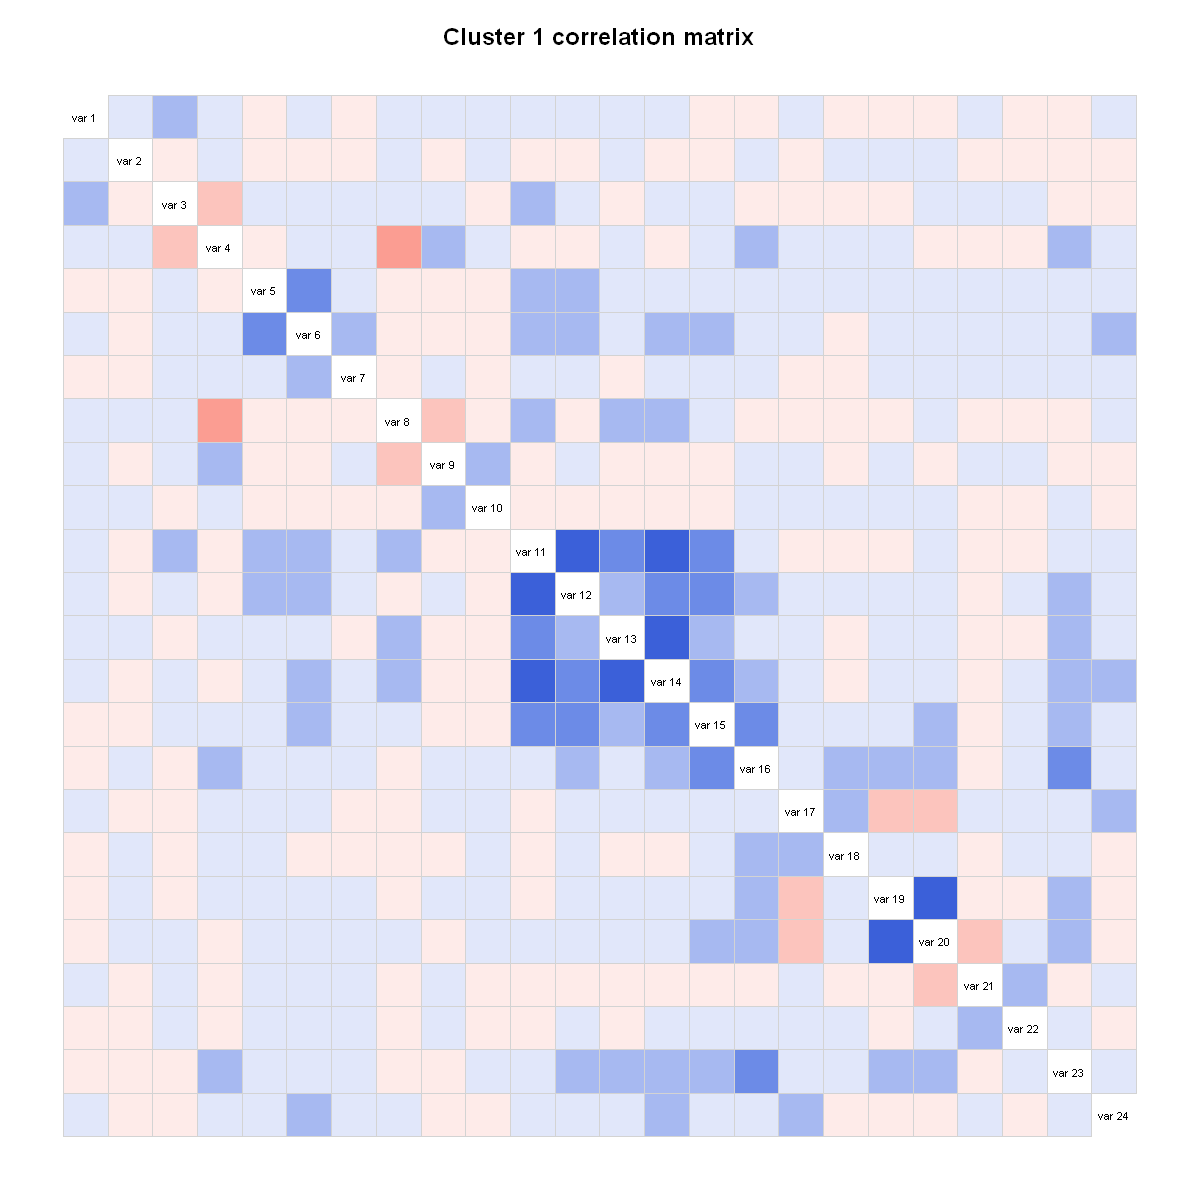

In [48]:
#Graphical display of the correlation matrix
options(repr.plot.width =10 , repr.plot.height =10)
corrgram(cor_cluster_1, lower.panel = panel.fill, upper.panel = panel.fill, main = "Cluster 1 correlation matrix")

Columns 19 and 20 (coworkers and supervisor): They have the highest correlation among the features in the cluster 1. This makes sense because, if someone does not want to discuss his mental health issue with a coworker, he does not want to discuss it with his supervisor either in most of the times.
Columns 11 and 12 (benefits and care_options): Both columns are asking a similar question about the mental health care benefits and is kind of duplicated.
Columns 13 and 14 (wellness_program and seek_help): Also these two columns have some overlapping information
Columns 11 and 14 (benefits and seek_help): It makes sense to be correlated because if there is no benefits available, you might not seek help either.

**cluster_2**

In [49]:
#Create the correlation matrix for cluster_2
cor_cluster_2= matrix(data = NA, nrow = ncol(cluster_2), ncol = ncol(cluster_2))

#Fill in the mi matrix
for (i in 1:ncol(cluster_2) ){
    for (j in 1:ncol(cluster_2) ){
        cor_cluster_2[i,j] = cor(as.integer(cluster_2[,i]), as.integer(cluster_2[,j]))
        }
    }
print(cor_cluster_2)

              [,1]         [,2]         [,3]          [,4]          [,5]
 [1,]  1.000000000  0.076246899  0.108028716  0.0881714224 -0.0173231749
 [2,]  0.076246899  1.000000000 -0.098676258  0.0585667757 -0.1398976042
 [3,]  0.108028716 -0.098676258  1.000000000 -0.0950603706  0.0675480505
 [4,]  0.088171422  0.058566776 -0.095060371  1.0000000000  0.0151211712
 [5,] -0.017323175 -0.139897604  0.067548050  0.0151211712  1.0000000000
 [6,]  0.031945153 -0.163890147  0.071706618  0.0107963846  0.4105774272
 [7,] -0.043949690 -0.037026084  0.020601250 -0.0711032548  0.0936337683
 [8,] -0.027863526 -0.053710436  0.081031561 -0.3578033400 -0.0643421548
 [9,]  0.061313911  0.043273709 -0.062668456  0.3457534823  0.0316170528
[10,]  0.062767617  0.074288915 -0.019949852  0.0864098984 -0.0127386054
[11,]  0.128278373 -0.119912920  0.050764209 -0.0200502704  0.0976878223
[12,]  0.051792360 -0.099803771  0.060910075  0.0837229940  0.0711892253
[13,]  0.070540335 -0.026721725  0.035068876 -0.002

In [50]:
#correlation between our response value and other features
sort(cor_cluster_2[,6], decreasing=TRUE)

[1]  1.0000000000  0.4105774272  0.2086787596  0.2043935615  0.1558380221
 [6]  0.1271903018  0.1086897508  0.1085850544  0.0780717434  0.0717066184
[11]  0.0660556260  0.0651137874  0.0536049814  0.0404442206  0.0360698048
[16]  0.0349076915  0.0319451530  0.0235550172  0.0235186095  0.0107963846
[21]  0.0006981714 -0.0348723004 -0.0604658541 -0.1638901475

The features are not very correlated with the response value. This makes it harder for our model to predict the treatment based off of the features.

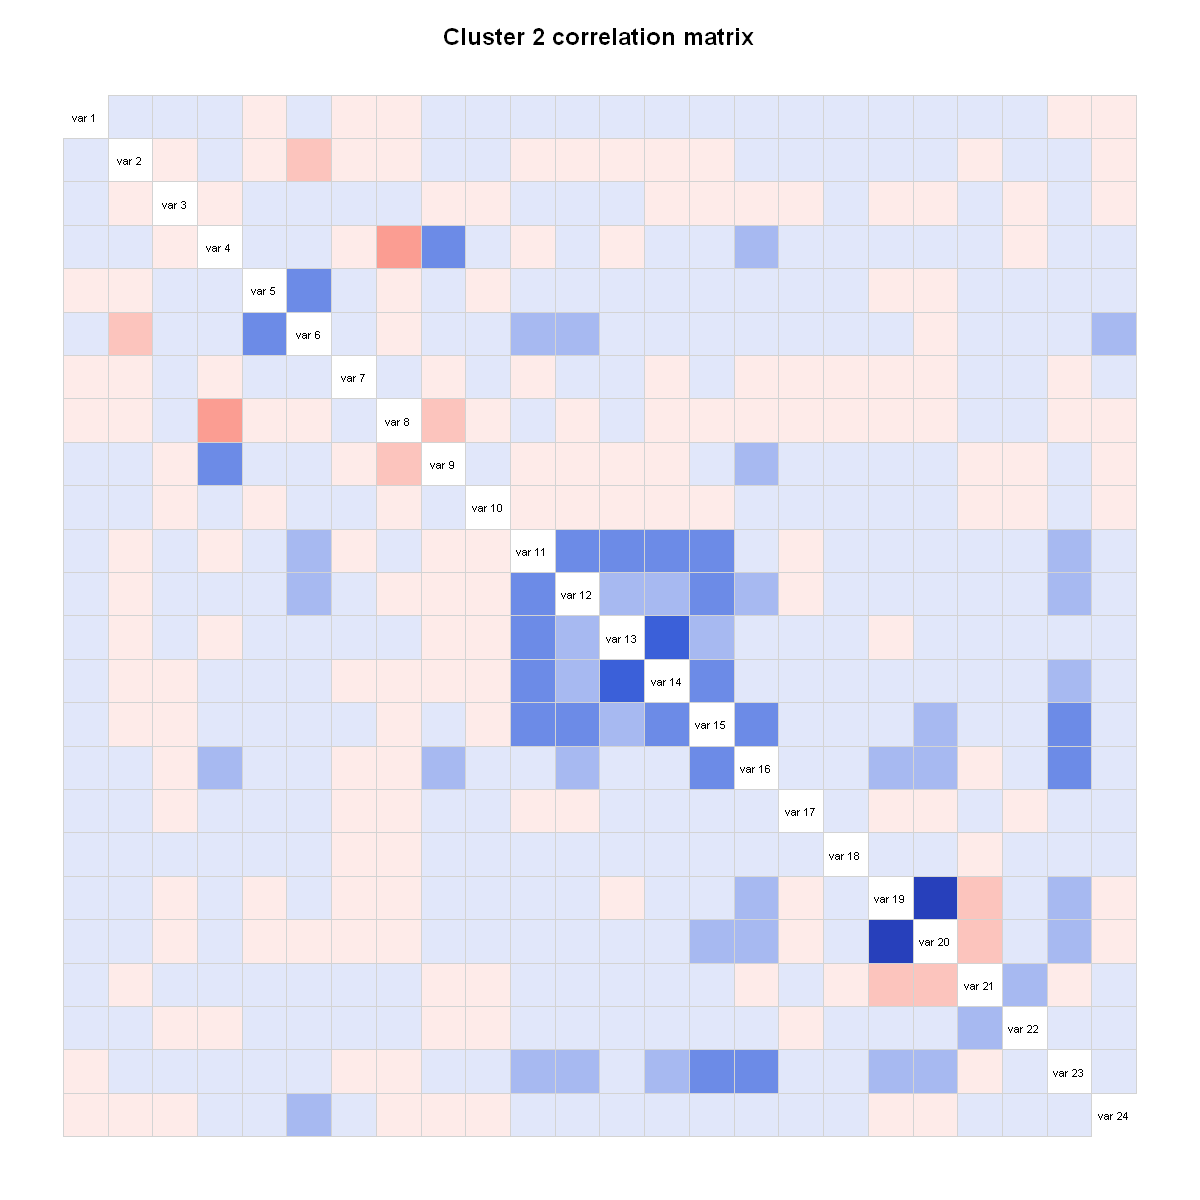

In [51]:
#Graphical display of the correlation matrix
options(repr.plot.width =10 , repr.plot.height =10)
corrgram(cor_cluster_2, lower.panel = panel.fill, , upper.panel = panel.fill, , main = "Cluster 2 correlation matrix")

Our features in cluster_2 are not that much correlated with each other either, however it is good that our features are not correlated with each other. 
In both clusters the features(except supervisor and coworker) do not have a correlation more than 0.5.

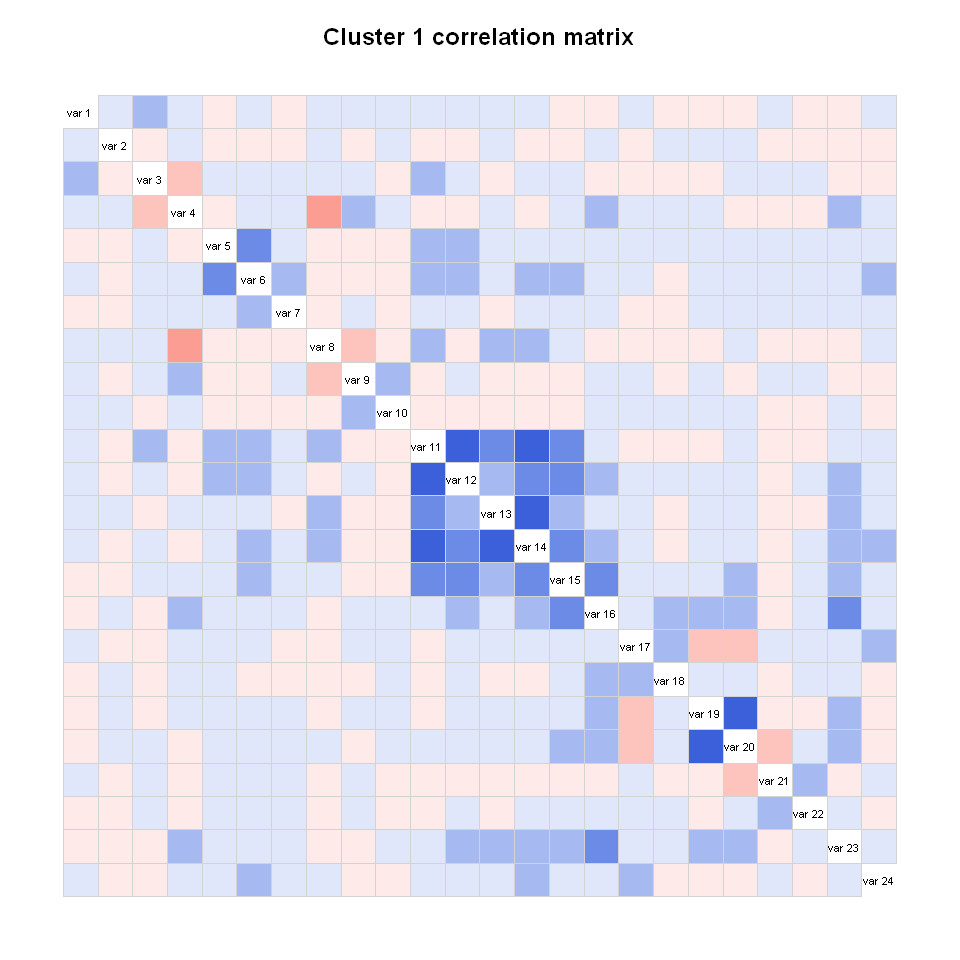

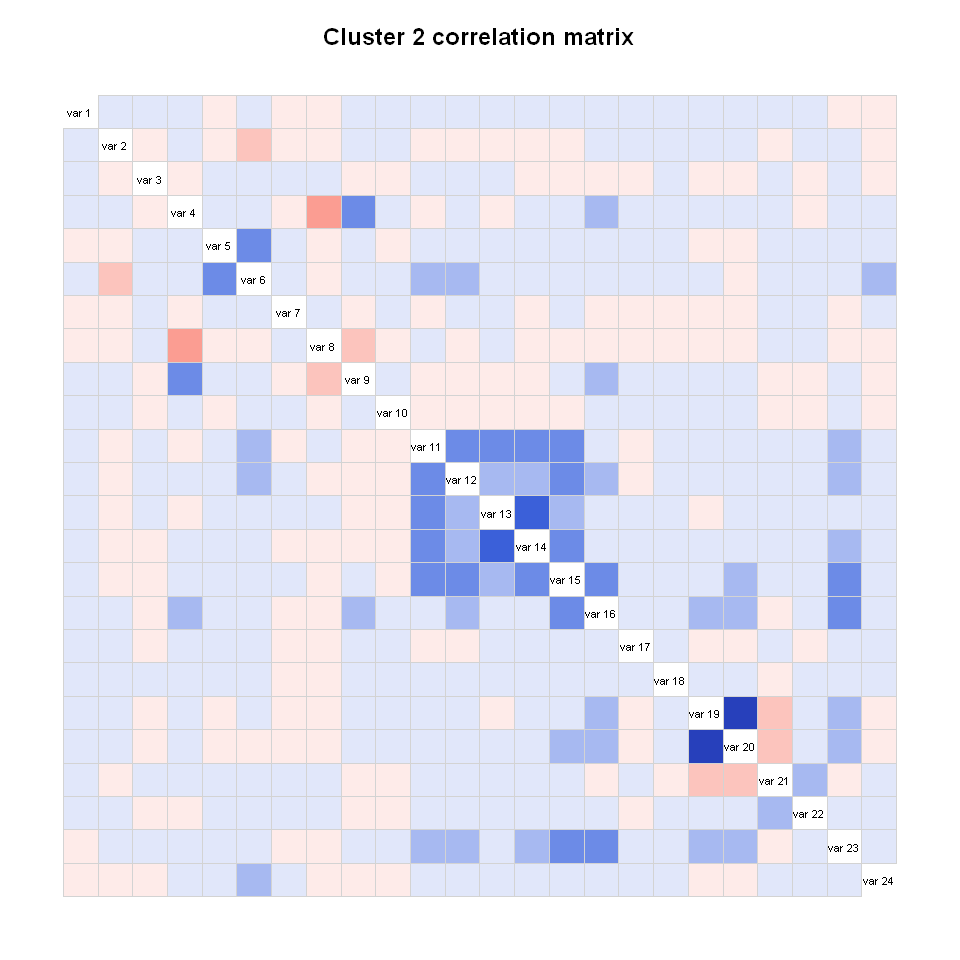

In [57]:
options(repr.plot.width =8 , repr.plot.height =8)
corrgram(cor_cluster_1, lower.panel = panel.fill, , upper.panel = panel.fill, , main = "Cluster 1 correlation matrix")
corrgram(cor_cluster_2, lower.panel = panel.fill, , upper.panel = panel.fill, , main = "Cluster 2 correlation matrix")

Comparing the correlation heat maps of cluster 1 and 2 shows us that the correlations between columns 11 and 12 and between columns 11 and 14 are greater in the cluster 1. \
Moreover, correlations between columns 19 and 20 and between columns 4 and 9 are greater in the cluster 2.